In [ ]:
# THIS IS INITIALIZATION AND PARAMETERS SECTION.


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import sklearn
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.manifold import TSNE
from pydeseq2 import dds, ds

# if you are reading this as PDF or HTML, the following value was set to 4.
pcs_count = int(input("input number of PCs needed in PCAs"))
# change this value to set palleete of plots.
palette = "tab10"

miR_data = pd.read_csv("data/miR.Counts.csv")
miR_data.set_index(miR_data["miRNA"], inplace=True)
miR_data.drop("miRNA", axis=1, inplace=True)
tRF_data = pd.read_csv("data/tRF.Counts.csv")
tRF_data.set_index(tRF_data["entry name"], inplace=True)
tRF_data.drop("entry name", axis=1, inplace=True)

# this is list of columns, containing data about examples with cysts.

cysts_list = {
    "1c_S43_R1_001": "mucinous",
    "7c_S44_R1_001": "mucinous",
    "32c_S45_R1_001": "mucinous",
    "4c_S46_R1_001": "serous",
    "6c_S47_R1_001": "serous",
    "34c_S48_R1_001": "serous",
}

mucinous_list = ["1c_S43_R1_001", "7c_S44_R1_001", "32c_S45_R1_001"]
serous_list = ["4c_S46_R1_001", "6c_S47_R1_001", "34c_S48_R1_001"]

# standardizing data
groups = [
    "no cyst" if i not in cysts_list.keys() else cysts_list[i] for i in miR_data.columns
]

# uncomment next line to see detailed information about exmaples with cysts
# groups = ["no cyst" if i not in cysts_list else i for i in miR_data.columns]

miR_data = miR_data.transpose()
tRF_data = tRF_data.transpose()
joined_data = miR_data.join(tRF_data)
scaler = StandardScaler()

cysts_only_df = joined_data.filter(list(cysts_list.keys()), axis=0)
cysts_only_std_df = scaler.fit_transform(cysts_only_df)
cyst_groups = [
    "mucinous",
    "mucinous",
    "mucinous",
    "serous",
    "serous",
    "serous",
]

cysts_only_mirna_df = miR_data.filter(list(cysts_list.keys()), axis=0)
cysts_only_mirna_std_df = scaler.fit_transform(cysts_only_mirna_df)

cysts_only_trna_df = tRF_data.filter(list(cysts_list.keys()), axis=0)
cysts_only_trna_std_df = scaler.fit_transform(cysts_only_trna_df)


# miRNAs analysis.
## Venn's Diagram


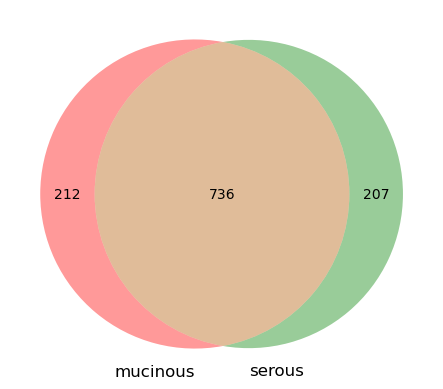

In [ ]:
# change parameter "RNA_count" to increase or decrease minimal count
RNA_min_count = 0

g1 = cysts_only_mirna_df.filter(mucinous_list, axis=0)
g2 = cysts_only_mirna_df.filter(serous_list, axis=0)

mucinous_rnas = set(g1.columns[(g1 > RNA_min_count).any()])
serous_rnas = set(g2.columns[(g2 > RNA_min_count).any()])

venn2((mucinous_rnas, serous_rnas), ("mucinous", "serous"))
plt.show()
unique_for_mucinous = mucinous_rnas - serous_rnas
unique_for_serous = serous_rnas - mucinous_rnas


## Unique miRNAs for serous group

In [ ]:
print("\n".join(unique_for_serous))


hsa-miR-6737-3p
hsa-miR-3191-3p
hsa-miR-1303-5p
hsa-miR-3179-3p
hsa-miR-517a-3p/517b-3p
hsa-miR-1251-3p
hsa-miR-4660
hsa-miR-6842-5p
hsa-miR-6871-5p
hsa-miR-6799-3p
hsa-miR-10400-5p
hsa-miR-6865-3p
hsa-miR-4498
hsa-miR-548at-3p
hsa-miR-6850-5p
hsa-miR-588-3p
hsa-miR-7108-3p
hsa-miR-6853-3p
hsa-miR-4637
hsa-miR-1908-5p
hsa-miR-6818-3p
hsa-miR-6864-5p
hsa-miR-548a-3p
hsa-miR-6833-3p
hsa-miR-4433a-5p
hsa-miR-1251-5p
hsa-miR-597-3p
hsa-miR-675-5p
hsa-miR-4790-3p
hsa-miR-4432
hsa-miR-1293-3p
hsa-miR-4474-3p
hsa-miR-548u-3p
hsa-miR-676-3p
hsa-miR-6743-3p
hsa-miR-4512-3p
hsa-miR-4667-5p
hsa-miR-6882-5p
hsa-miR-3166
hsa-miR-4762-5p
hsa-miR-6877-3p
hsa-miR-6807-3p
hsa-miR-3150b-3p
hsa-miR-4422-5p
hsa-miR-1908-3p
hsa-miR-4804-5p
hsa-miR-6805-5p
hsa-miR-326-3p
hsa-miR-939-3p
hsa-miR-6840-5p
hsa-miR-887-5p
hsa-miR-1269b
hsa-miR-767-3p
hsa-miR-4699-5p
hsa-miR-518b
hsa-miR-1226-5p
hsa-miR-6883-3p
hsa-miR-7854-3p
hsa-miR-4787-3p
hsa-miR-6721-5p
hsa-miR-155-3p
hsa-miR-3158-5p
hsa-miR-3652-5p
hsa-miR-7

## Unique for mucinous group

In [ ]:
print("\n".join(unique_for_mucinous))


hsa-miR-1293-5p
hsa-miR-487a-5p
hsa-miR-578-5p
hsa-miR-4800-3p
hsa-miR-495-5p
hsa-miR-3133
hsa-miR-655-3p
hsa-miR-6767-5p
hsa-miR-4497
hsa-miR-6715b-5p
hsa-miR-7974
hsa-miR-933
hsa-miR-9983-3p
hsa-miR-6824-3p
hsa-miR-1910-5p
hsa-miR-6829-5p
hsa-miR-492
hsa-miR-549a-5p
hsa-miR-656-3p
hsa-miR-3165-3p
hsa-miR-6744-5p
hsa-miR-888-5p
hsa-miR-665-3p
hsa-miR-4793-3p
hsa-miR-412-5p
hsa-miR-1972
hsa-miR-1185-1-3p/1185-2-3p
hsa-miR-4697-3p
hsa-miR-6811-5p
hsa-miR-9986
hsa-miR-4731-5p
hsa-miR-516a-5p
hsa-miR-5571-3p
hsa-miR-550b-3p
hsa-miR-3916
hsa-miR-3085-3p
hsa-miR-3921-3p
hsa-miR-4739
hsa-miR-548ag-3p
hsa-miR-4442
hsa-miR-3913-3p
hsa-let-7a-2-3p
hsa-miR-650
hsa-miR-5590-5p
hsa-miR-1248
hsa-miR-2116-5p
hsa-miR-5699-3p
hsa-miR-3162-5p
hsa-miR-10396a-5p/10396b-5p
hsa-miR-4536-3p
hsa-miR-551a
hsa-miR-449b-3p
hsa-miR-217-3p
hsa-miR-6770-5p
hsa-miR-1244
hsa-miR-134-3p
hsa-miR-6757-3p
hsa-miR-4708-3p
hsa-miR-3622a-5p
hsa-miR-216a-5p
hsa-miR-4640-3p
hsa-miR-497-3p
hsa-miR-299-5p
hsa-miR-5697-3p
hsa-m

## PCA of Cysts.miRNA dataset

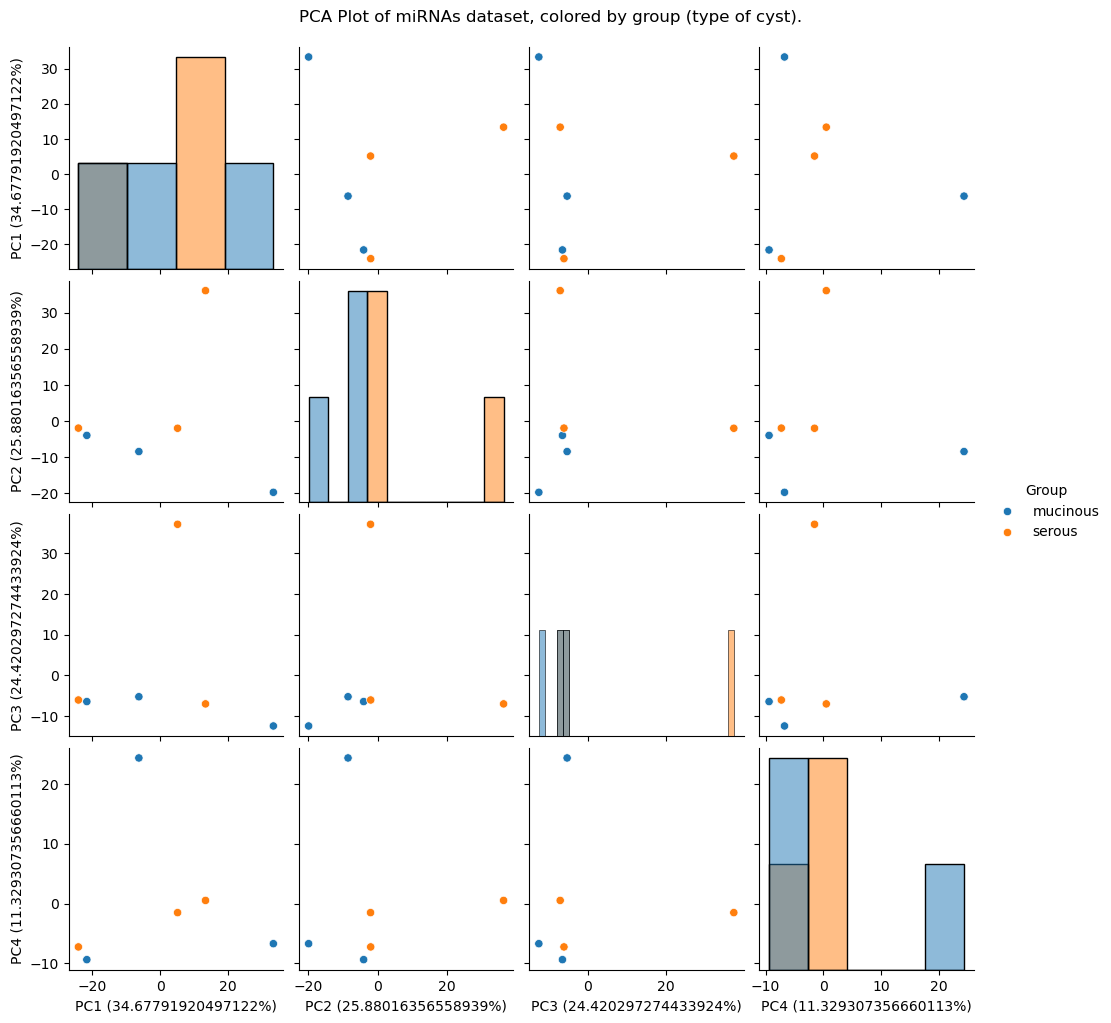

In [ ]:
miRNA_PCA = sklearn.decomposition.PCA(pcs_count)
miRNA_transformed = miRNA_PCA.fit_transform(cysts_only_mirna_std_df)
miRNA_explained_variance = miRNA_PCA.explained_variance_
miRNA_explained_variance_ratio = miRNA_PCA.explained_variance_ratio_
miRNA_pca_df = pd.DataFrame(
    {
        f"PC{i + 1} ({miRNA_explained_variance_ratio[i] * 100}%)": miRNA_transformed[
            :, i
        ]
        for i in range(pcs_count)
    }
)
miRNA_pca_df["Group"] = [cysts_list[i] for i in cysts_list]

sns.pairplot(
    data=miRNA_pca_df,
    hue="Group",
    palette=palette,
    diag_kind="hist",
    plot_kws={"alpha": 1},
)
plt.suptitle("PCA Plot of miRNAs dataset, colored by group (type of cyst).", y=1.02)
plt.show()


## tSNE analysis of Cysts.miRNA dataset. 

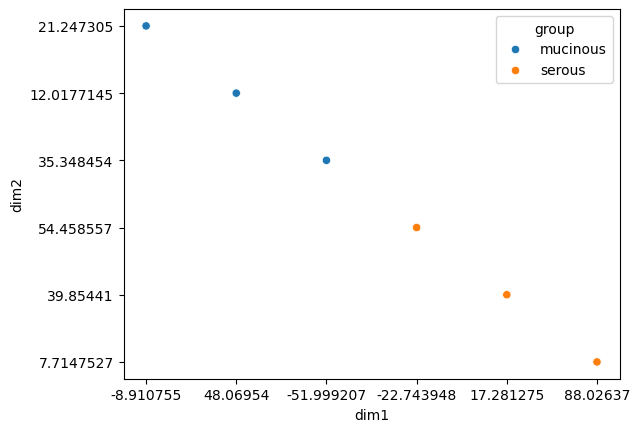

In [ ]:
tsne_mirna_cysts = np.vstack(
    (
        TSNE(
            n_components=2,
            perplexity=3,
            init="random",
            learning_rate="auto",
        )
        .fit_transform(cysts_only_mirna_df)
        .T,
        cyst_groups,
    )
).T

tsne_mirna_df = pd.DataFrame(tsne_mirna_cysts, columns=("dim1", "dim2", "group"))


sns.scatterplot(data=tsne_mirna_df, x="dim1", y="dim2", hue="group", palette=palette)
plt.show()


# tRNAs analysis.
## Venn's Diagram


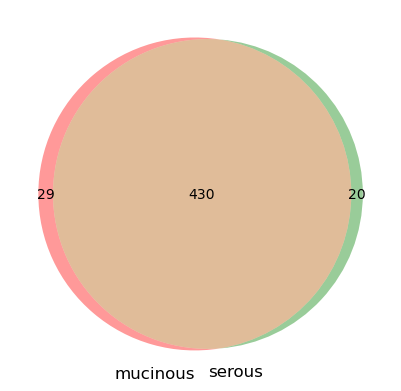

In [ ]:
g1 = cysts_only_trna_df.filter(mucinous_list, axis=0)
g2 = cysts_only_trna_df.filter(serous_list, axis=0)

mucinous_rnas = set(g1.columns[(g1 > RNA_min_count).any()])
serous_rnas = set(g2.columns[(g2 > RNA_min_count).any()])

venn2((mucinous_rnas, serous_rnas), ("mucinous", "serous"))
plt.show()
unique_for_mucinous = mucinous_rnas - serous_rnas
unique_for_serous = serous_rnas - mucinous_rnas


## Unique miRNAs for serous group

In [ ]:
print("\n".join(unique_for_serous))


Ala_Comb_20
Thr_Comb_24
Leu_Comb_29
His_Comb_18
Ala_Comb_19
Ser_Comb_21
Val_Comb_13
Ser_Comb_23
Asn_Comb_8
Leu_Comb_28
Arg_Comb_52
Gly_Comb_11
Gly_Comb_18
Gln_Comb_1
Trp_Comb_8
Arg_Comb_33
Arg_Comb_22
Arg_Comb_27
Ile_Comb_10
Gln_Comb_13


## Unique for mucinous group

In [ ]:
print("\n".join(unique_for_mucinous))


Thr_Comb_25
Leu_Comb_33
Ser_Comb_7
Gln_Comb_23
Leu_Comb_25
Gly_Comb_31
Pro_Comb_9
Asp_Comb_12
Gln_Comb_16
Arg_Comb_49
Arg_Comb_14
Thr_Comb_13
Phe_Comb_15
Val_Comb_16
Arg_Comb_15
Asp_Comb_14
Gln_Comb_11
Lys_Comb_10
Glu_Comb_19
SeC_Comb_8
Gly_Comb_14
Arg_Comb_19
Glu_Comb_13
Ile_Comb_23
Thr_Comb_29
Thr_Comb_16
Ser_Comb_2
Glu_Comb_5
Leu_Comb_17


## PCA of Cysts.tRNA dataset

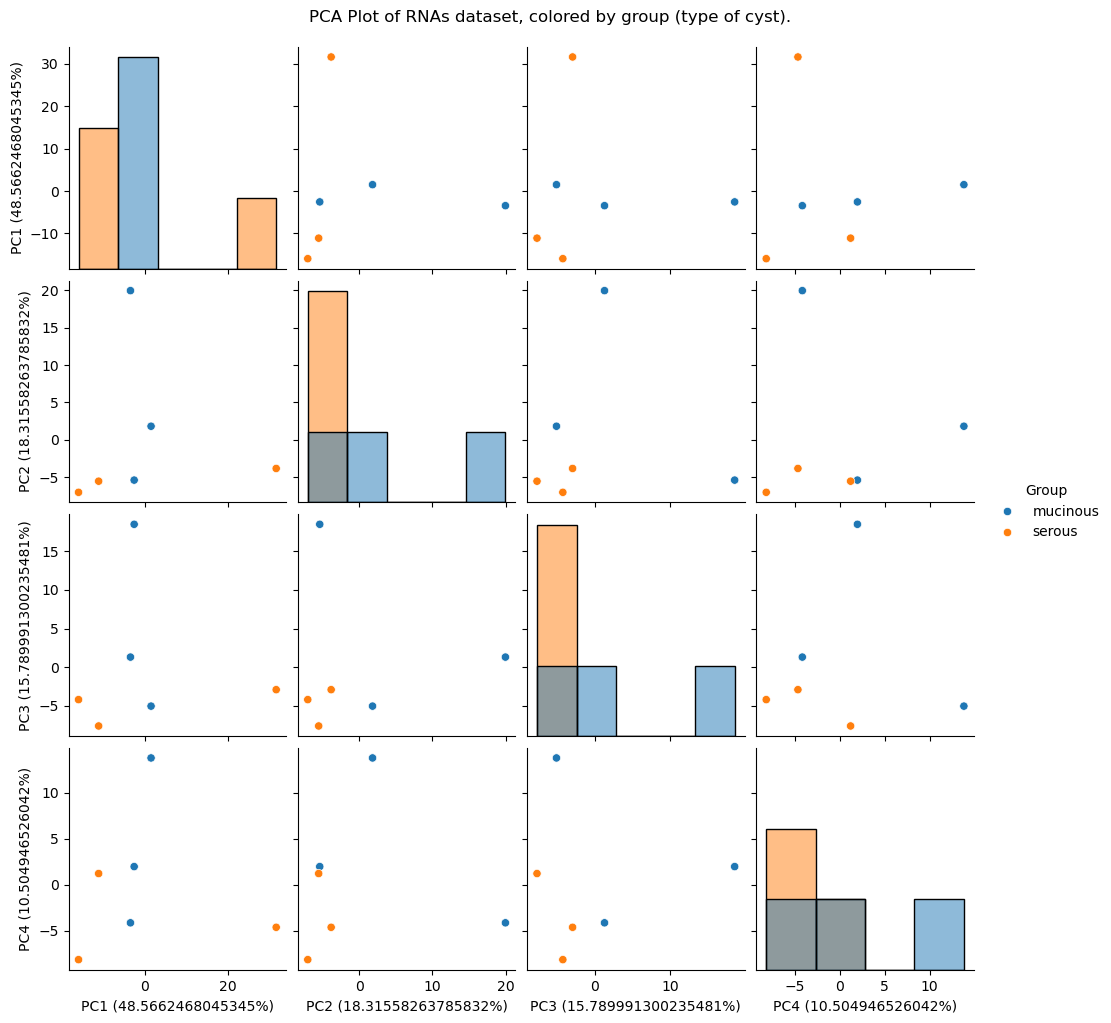

In [ ]:
tRNA_PCA = sklearn.decomposition.PCA(pcs_count)
tRNA_transformed = tRNA_PCA.fit_transform(cysts_only_trna_std_df)
tRNA_explained_variance = tRNA_PCA.explained_variance_
tRNA_explained_variance_ratio = tRNA_PCA.explained_variance_ratio_
tRNA_pca_df = pd.DataFrame(
    {
        f"PC{i + 1} ({tRNA_explained_variance_ratio[i] * 100}%)": tRNA_transformed[:, i]
        for i in range(pcs_count)
    }
)
tRNA_pca_df["Group"] = [cysts_list[i] for i in cysts_list]

sns.pairplot(
    data=tRNA_pca_df,
    hue="Group",
    palette=palette,
    diag_kind="hist",
    plot_kws={"alpha": 1},
)
plt.suptitle("PCA Plot of RNAs dataset, colored by group (type of cyst).", y=1.02)
plt.show()


## tSNE analysis of Cysts.tRNA dataset. 

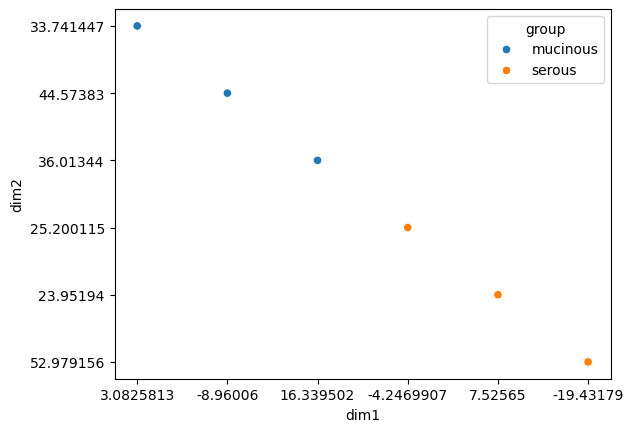

In [ ]:
tsne_trna_cysts = np.vstack(
    (
        TSNE(
            n_components=2,
            perplexity=3,
            init="random",
            learning_rate="auto",
        )
        .fit_transform(cysts_only_mirna_df)
        .T,
        cyst_groups,
    )
).T

tsne_trna_df = pd.DataFrame(tsne_trna_cysts, columns=("dim1", "dim2", "group"))


sns.scatterplot(data=tsne_trna_df, x="dim1", y="dim2", hue="group", palette=palette)
plt.show()


# PCA of combined miRNA and tRNA datasets.
The use of a combined dataset is necessitated by the difficulty of differentiating groups using either the miRNA or tRNA dataset.

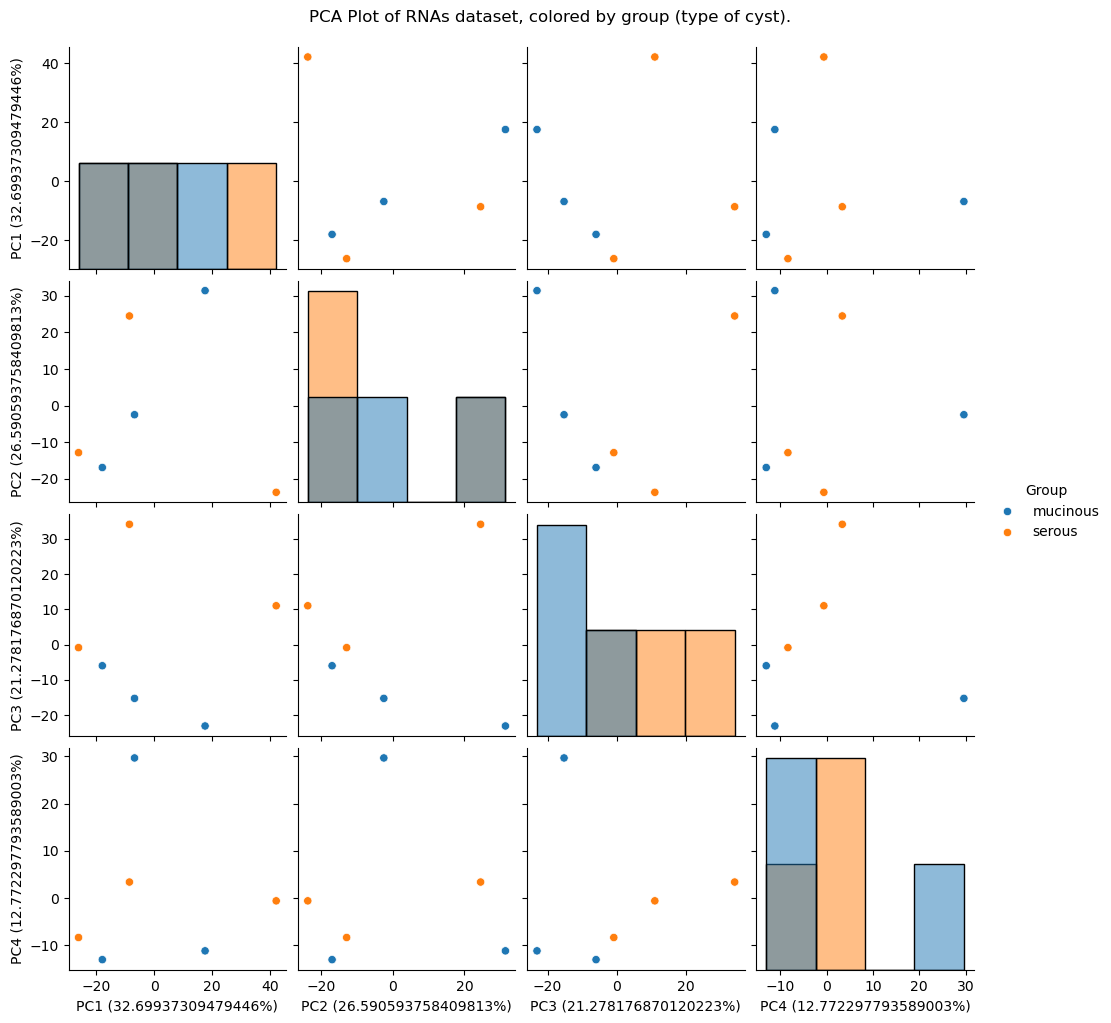

In [ ]:
combined_PCA = sklearn.decomposition.PCA(pcs_count)
RNA_transformed = combined_PCA.fit_transform(cysts_only_std_df)
RNA_explained_variance = combined_PCA.explained_variance_
RNA_explained_variance_ratio = combined_PCA.explained_variance_ratio_
RNA_pca_df = pd.DataFrame(
    {
        f"PC{i + 1} ({RNA_explained_variance_ratio[i] * 100}%)": RNA_transformed[:, i]
        for i in range(pcs_count)
    }
)
RNA_pca_df["Group"] = [cysts_list[i] for i in cysts_list]

sns.pairplot(
    data=RNA_pca_df,
    hue="Group",
    palette=palette,
    diag_kind="hist",
    plot_kws={"alpha": 1},
)
plt.suptitle("PCA Plot of RNAs dataset, colored by group (type of cyst).", y=1.02)
plt.show()


# Analysis with PyDeSeq2

In [ ]:
metadata = pd.DataFrame({"example": list(cysts_list.keys()), "condition": cyst_groups})
metadata.set_index(metadata["example"], inplace=True)
metadata.drop("example", axis=1, inplace=True)
dds_df = dds.DeseqDataSet(counts=cysts_only_df, metadata=metadata)
dds_df.deseq2()
ds_df = ds.DeseqStats(dds_df, alpha=0.05, cooks_filter=False, independent_filter=False)
ds_df.summary()
results = ds_df.results_df
results.dropna(inplace=True)
results.to_csv(open("DeSeqStats_results_no_NaNs.csv", "w"))
